In [1]:
%load_ext autoreload

%autoreload 2

# Duffing Resonator Example NPAD

In [2]:
from dataclasses import dataclass

import sympy as smp
from sympy import init_printing

init_printing()
from dataclasses import field
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from joblib import Parallel, delayed
from tqdm.auto import tqdm

from qcheff.cpu.npad import (
    npad_decouple_sim,
    npad_diagonalize,
    npad_eliminate_couplings,
    npad_eliminate_couplings_simultaneous,
)
from qcheff.cpu.utils import extract_num_params

mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 25
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["lines.markersize"] = 8
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["axes.titlesize"] = 20

import sympy


@dataclass(frozen=True)
class DuffingOscQubit:
    omega: float
    alpha: float
    ntrunc: int = field(default=5)


@dataclass(frozen=True)
class Resonator:
    omega: float
    ntrunc: int = field(default=3)


@dataclass(frozen=True)
class ResonatorCoupledDuffingQubits:
    qubit1: DuffingOscQubit
    qubit2: DuffingOscQubit
    resonator: Resonator
    g: float


def create_duffingresonator_system(
    delp: float,
    delm: float,
    ntrunc: int = 4,
    alpha1: float = -0.33,  # GHz
    alpha2: float = -0.33,  # GHz
    g: float = 0.05,  # GHz
):
    """
    Assume some sensible default parameters.
    """
    wr = 3  # GHz #probably a a sensible value
    del1 = 0.5 * (delp + delm)
    del2 = 0.5 * (delp - delm)

    w1 = del1 + wr
    w2 = del2 + wr

    return ResonatorCoupledDuffingQubits(
        qubit1=DuffingOscQubit(omega=w1, alpha=alpha1, ntrunc=ntrunc),
        qubit2=DuffingOscQubit(omega=w2, alpha=alpha2, ntrunc=ntrunc),
        resonator=Resonator(omega=wr, ntrunc=ntrunc),
        g=g,
    )


def full_numerical_ham(example) -> np.ndarray:
    """
    Returns the full Hamiltonian matrix (Eq. 24)
    """
    N1 = example.qubit1.ntrunc
    N2 = example.qubit2.ntrunc
    Nr = example.resonator.ntrunc

    I1 = qt.qeye(N1)
    I2 = qt.qeye(N2)
    Ir = qt.qeye(Nr)

    b1 = qt.destroy(N1) & I2 & Ir
    b2 = I1 & qt.destroy(N2) & Ir
    ar = I1 & I2 & qt.destroy(Nr)

    num1 = b1.dag() @ b1
    kerr1 = b1.dag() @ b1.dag() @ b1 @ b1

    num2 = b2.dag() @ b2
    kerr2 = b2.dag() @ b2.dag() @ b2 @ b2

    numr = ar.dag() @ ar

    H1 = example.qubit1.omega * num1[:] + 0.5 * example.qubit1.alpha * kerr1[:]
    H2 = example.qubit2.omega * num2[:] + 0.5 * example.qubit2.alpha * kerr2[:]
    H3 = example.resonator.omega * numr[:]

    H1r = example.g * (b1 @ ar.dag() + b1.dag() @ ar)[:]
    H2r = example.g * (b2 @ ar.dag() + b2.dag() @ ar)[:]
    H = H1 + H2 + H3 + H1r + H2r

    return H


def create_overlap_matrix(esys):
    return np.hstack([evec[:] for evec in esys])


def dressed_labels(esys):
    return np.argmax(np.abs(create_overlap_matrix(esys)), axis=1)


def plot_matelm_mag(H: np.ndarray, scale="log"):
    fig, ax = plt.subplots(1, 1, layout="constrained")
    absH = np.abs(H)
    P1 = ax.imshow(
        absH,
        cmap="binary",
        norm=mpl.colors.LogNorm(vmin=1e-10) if scale == "log" else None,
    )
    ax.set(xticks=[], yticks=[])
    plt.colorbar(P1, ax=ax)


def plot_offdiag_mag(H: np.ndarray, scale="log"):
    plot_matelm_mag(H - np.diag(np.diagonal(H)), scale=scale)


def numerical_qubit_subspace_spectrum(example):
    """
    Returns the eigenvalues E00, E01, E10, E11
    """
    evals, evecs = qt.Qobj(full_numerical_ham(example)).eigenstates()
    dims = [example.qubit1.ntrunc, example.qubit2.ntrunc, example.resonator.ntrunc]
    dressed_idx = dressed_labels(evecs)
    E11 = (evals[dressed_idx])[qt.state_number_index(dims, [1, 1, 0])]
    E10 = (evals[dressed_idx])[qt.state_number_index(dims, [1, 0, 0])]
    E01 = (evals[dressed_idx])[qt.state_number_index(dims, [0, 1, 0])]
    E00 = (evals[dressed_idx])[qt.state_number_index(dims, [0, 0, 0])]
    return [E00, E01, E10, E11]


def full_numerical_zz(delp, delm) -> float:
    """
    Calculates static ZZ interaction strength numerically from the full Hamiltonian. Eq 24

    """
    E00, E01, E10, E11 = numerical_qubit_subspace_spectrum(
        create_duffingresonator_system(delp, delm)
    )
    return E11 + E00 - E01 - E10

We will create a test system and the plot the Hamiltonian

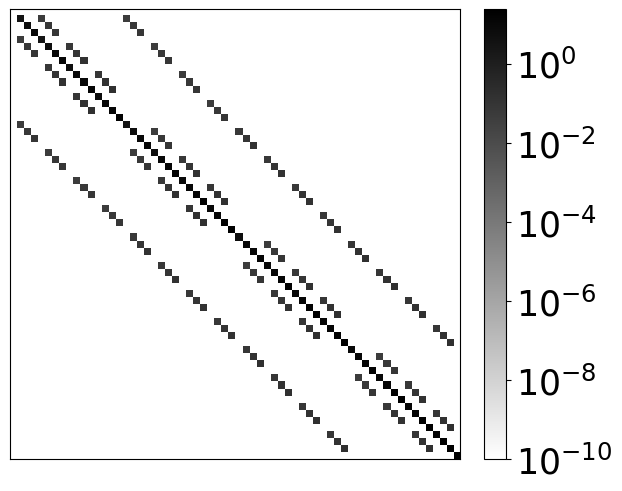

In [4]:
test_sys = create_duffingresonator_system(delp=-0.5, delm=0.3)
test_ham = full_numerical_ham(test_sys)
system_dims = [
    test_sys.qubit1.ntrunc,
    test_sys.qubit2.ntrunc,
    test_sys.resonator.ntrunc,
]
plot_matelm_mag(test_ham)

This system has 3 components with 4 levels each. So there are 4^3 =64 levels. First, we need to identify the levels we are interested in. These should be states where the resonator is unpopulated. Then, we need to indentify all nonzero couplings between these states and any other states and label them appropriately. 

In [5]:
all_levels = list(qt.state_number_enumerate(system_dims))
zz_levels = [label for label in all_levels if label[2] == 0 and max(label) <= 1]
other_levels = [label for label in all_levels if label not in zz_levels]
zz_levels, other_levels

Now that we have identified labels for each set of levels, we need to find their indices in the matrix (so that we can either reorganize it, or just find the list of couplings).

In [6]:
zz_idx = np.asarray([qt.state_number_index(system_dims, label) for label in zz_levels])
other_idx = np.asarray(
    [qt.state_number_index(system_dims, label) for label in other_levels]
)

In [7]:
zz_idx

array([ 0,  4, 16, 20])

Now, we can find the couping matrix. This will not be square.

In [8]:
coupling1_offdiags = test_ham[np.ix_(zz_idx, other_idx)]
nonzero_couplings1_idx = [
    (zz_idx[a], other_idx[b])
    for a, b in zip(*coupling1_offdiags.nonzero(), strict=False)
]
nonzero_coupling1_labels = [
    (zz_levels[a], other_levels[b])
    for a, b in zip(*coupling1_offdiags.nonzero(), strict=False)
]
[f"{a} - {b}" for a, b in nonzero_coupling1_labels]
# plot_matelm_mag(coupling_offdiags)

['(0, 1, 0) - (0, 0, 1)',
 '(1, 0, 0) - (0, 0, 1)',
 '(1, 1, 0) - (0, 1, 1)',
 '(1, 1, 0) - (1, 0, 1)']

In [9]:
nonzero_couplings1_idx

[(4, 1), (16, 1), (20, 5), (20, 17)]

In [10]:
test_ham[4, 1], test_ham[16, 1], test_ham[20, 5], test_ham[20, 17]

((0.05+0j), (0.05+0j), (0.05+0j), (0.05+0j))

From this, we can see there are 4 nonzero single-photon couplings we need to eliminate. We will use NPAD to eliminate them.

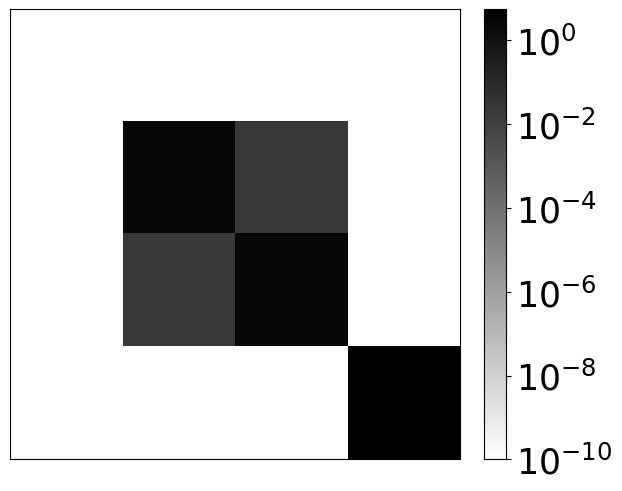

In [11]:
npad_zz_ham = npad_decouple_sim(test_ham, zz_idx, other_idx, debug=False, batch_size=1)[
    np.ix_(zz_idx, zz_idx)
]
plot_matelm_mag(npad_zz_ham)

Here we can also compare the effect of sequential v/s simulataneous NPAD

((-0.0022427247564701094+0j),
 (2.005411860143328e-18+0j),
 (-0.002064078140453399+0j),
 (7.997971757484155e-17+0j))

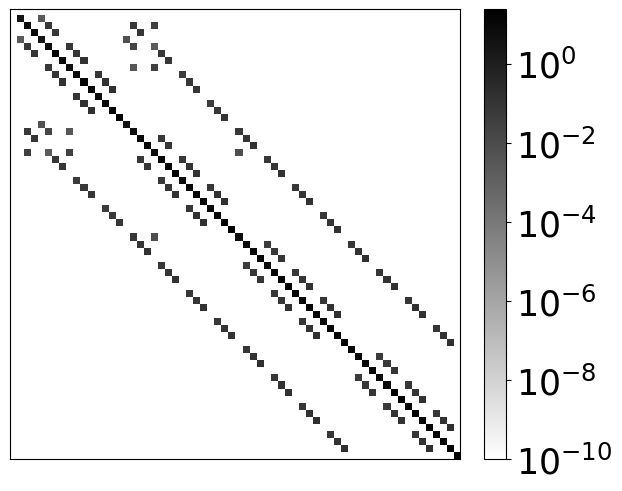

In [12]:
# npad1_ham = npad_eliminate_couplings_simultaneous(test_ham, nonzero_couplings_idx)
# npad1_ham = npad_eliminate_couplings(test_ham, nonzero_couplings1_idx + [(4, 16)])
npad1_ham = npad_eliminate_couplings(test_ham, nonzero_couplings1_idx)
plot_matelm_mag(npad1_ham)
npad1_ham[4, 1], npad1_ham[16, 1], npad1_ham[20, 5], npad1_ham[20, 17]

(1.7604930155901144e-05+0j)


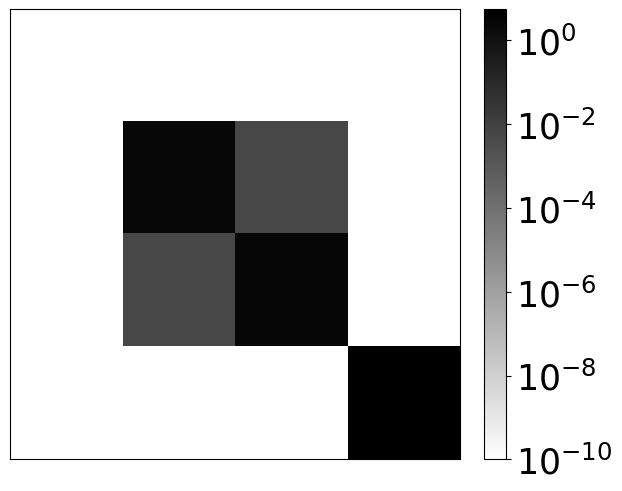

In [13]:
npad1_cz_ham = npad1_ham[np.ix_(zz_idx, zz_idx)]
E00, E01, E10, E11 = np.diag(npad1_cz_ham)
print(E11 + E00 - E01 - E10)
plot_matelm_mag(npad1_cz_ham)

Since the matrix in the required subspace is not diagonal, we can't use this yet. However, for academic purposes, try doing a sweep.

Text(0, 0.5, '$|\\zeta|$ (MHz)')

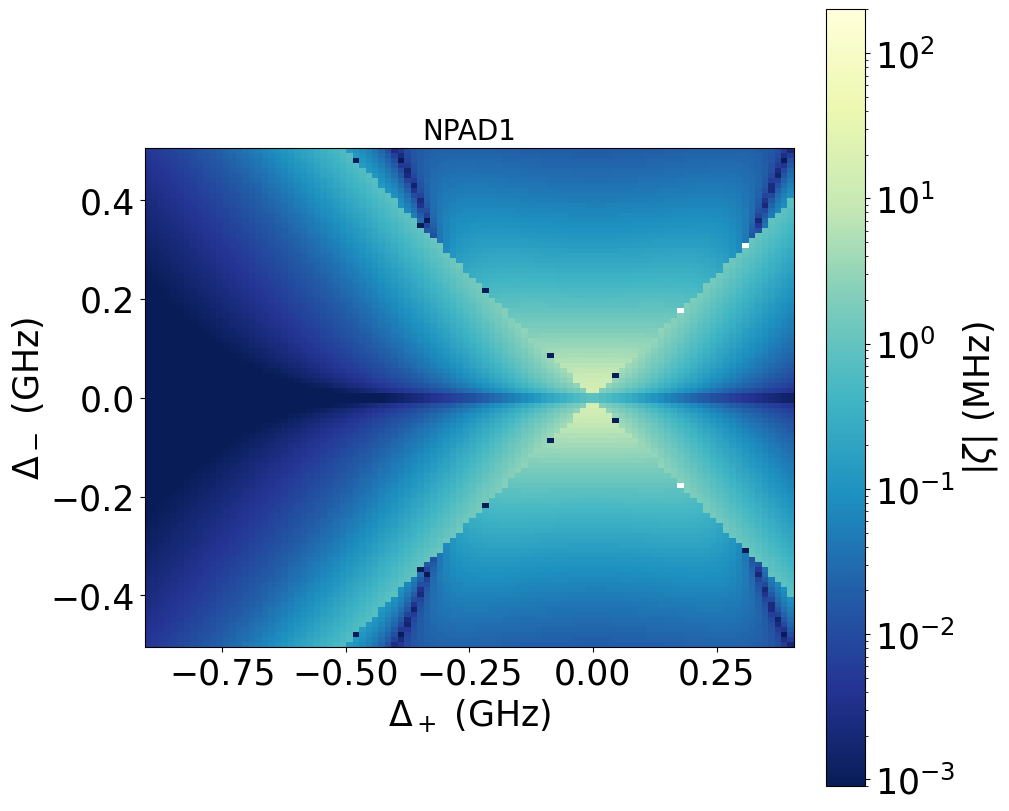

In [14]:
def npad1_zz(delp, delm):
    test_sys = create_duffingresonator_system(delp=delp, delm=delm)
    test_ham = full_numerical_ham(test_sys)
    zz_npad_couplings = [(4, 1), (16, 1), (20, 5), (20, 17)]
    zz_idx = [0, 4, 16, 20]
    npad1_ham = npad_eliminate_couplings_simultaneous(test_ham, zz_npad_couplings)
    npad_cz_ham = npad1_ham[np.ix_(zz_idx, zz_idx)]
    E00, E01, E10, E11 = np.diag(npad_cz_ham)
    return E11 + E00 - E01 - E10


N = 100
delp_list = np.linspace(-0.9, 0.4, N)
delm_list = np.linspace(-0.5, 0.5, N)


npad1_zz_list = np.vstack(
    Parallel(n_jobs=-2, verbose=0)(
        delayed(npad1_zz)(delp, delm) for delm in delm_list for delp in delp_list
    )
)

fig, ax = plt.subplots(
    1,
    1,
    layout="constrained",
    figsize=(10, 8),
    sharex=True,
    sharey=True,
)
pm1 = ax.pcolormesh(
    delp_list,
    delm_list,
    np.abs(npad1_zz_list.reshape(delm_list.shape[0], delp_list.shape[0])) * 1e3,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(vmin=9e-4, vmax=2e2),
)
ax.set(
    title="NPAD1",
    aspect="equal",
    xlabel=r"$\Delta_+$ (GHz)",
    ylabel=r"$\Delta_-$ (GHz)",
)

cbar = fig.colorbar(pm1)
cbar.ax.set_ylabel(r"$|\zeta|$ (MHz)")

Now we repeat again

In [15]:
coupling2_offdiags = npad1_ham[np.ix_(zz_idx, other_idx)]
nonzero_couplings2_locs = list(zip(*coupling2_offdiags.nonzero(), strict=False))
nonzero_couplings2_idx = [(zz_idx[a], other_idx[b]) for a, b in nonzero_couplings2_locs]
nonzero_coupling2_labels = [
    (zz_levels[a], other_levels[b]) for a, b in nonzero_couplings2_locs
]
[f"{a} - {b}" for a, b in nonzero_coupling2_labels]
# plot_matelm_mag(coupling_offdiags)

['(0, 1, 0) - (0, 0, 1)',
 '(1, 0, 0) - (0, 0, 1)',
 '(1, 1, 0) - (0, 0, 2)',
 '(1, 1, 0) - (0, 1, 1)',
 '(1, 1, 0) - (0, 2, 0)',
 '(1, 1, 0) - (1, 0, 1)',
 '(1, 1, 0) - (2, 0, 0)']

In [16]:
list(set(nonzero_coupling2_labels) - set(nonzero_coupling1_labels))

these are the 2 photon couplings we need to remove. in addition to the effective qubit-qubit 2-photon interaction.

In [17]:
# Adding in qubit qubit effective coupling at (4, 16)
twophoton_couplings_dx = np.sort(
    np.asarray(list({*nonzero_couplings2_idx, (4, 16)} - set(nonzero_couplings1_idx))),
    axis=1,
)[:, ::-1]
twophoton_couplings_dx

array([[20,  2],
       [16,  4],
       [20,  8],
       [32, 20]])

((-0.0022422842915968684+0j),
 (4.44464727716649e-05+0j),
 (-0.0005564235370191315+0j),
 (-0.03886869526860349+0j))

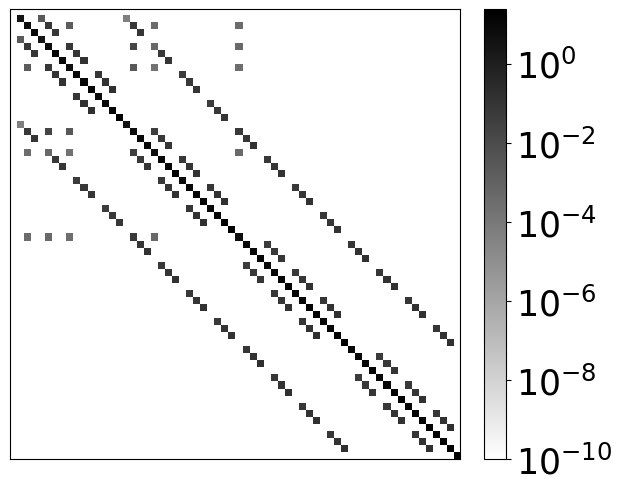

In [18]:
npad2_ham = npad_eliminate_couplings_simultaneous(npad1_ham, twophoton_couplings_dx)
# npad2_ham = npad_eliminate_couplings(npad1_ham,twophoton_couplings_dx)
plot_matelm_mag(npad2_ham)
npad2_ham[4, 1], npad2_ham[16, 1], npad2_ham[20, 5], npad2_ham[20, 17]

In [19]:
np.diag(npad2_ham)[5]

(5.620710678118655+0j)

In [20]:
np.linalg.eigvalsh(test_ham)

array([ 0.        ,  2.59372044,  2.88052725,  3.02575231,  4.86313632,
        5.45499133,  5.47691038,  5.61518855,  5.88080925,  6.04896417,
        6.8029171 ,  7.70005903,  7.7423303 ,  7.88408626,  8.05270604,
        8.45727117,  8.47370213,  8.63379096,  8.88258278,  9.07055424,
        9.68098337,  9.81780674, 10.29164372, 10.32393812, 10.69674427,
       10.73638305, 10.90230429, 11.05181278, 11.46522733, 11.47554688,
       11.66599807, 11.9516114 , 12.2609364 , 12.56346074, 12.66733314,
       12.8295453 , 13.28315059, 13.32206782, 13.69407961, 13.74047702,
       13.93665535, 14.05526674, 14.502927  , 14.5043378 , 14.56268948,
       15.25222143, 15.55399447, 15.66429862, 15.8582438 , 16.27804751,
       16.32378132, 16.72596583, 16.82041283, 17.12010719, 17.48608822,
       18.24758159, 18.54707595, 18.74103591, 19.32158403, 19.3966343 ,
       20.4718543 , 21.30592123, 21.60222447, 23.52      ])

In [21]:
evals, evecs = qt.Qobj(test_ham).eigenstates()
dims = [test_sys.qubit1.ntrunc, test_sys.qubit2.ntrunc, test_sys.resonator.ntrunc]
dressed_idx = dressed_labels(evecs)
E11 = (evals[dressed_idx])[qt.state_number_index(dims, [1, 1, 0])]
E10 = (evals[dressed_idx])[qt.state_number_index(dims, [1, 0, 0])]
E01 = (evals[dressed_idx])[qt.state_number_index(dims, [0, 1, 0])]
E00 = (evals[dressed_idx])[qt.state_number_index(dims, [0, 0, 0])]
# npad_cz_ham = npad2_ham[np.ix_(zz_idx, zz_idx)]
# E00, E01, E10, E11 = np.diag(npad_cz_ham)
# return (E11 + E00 - E01 - E10)
E11, E10, E01, E00
# dressed_idx

(0.0051028381691935465+0j)


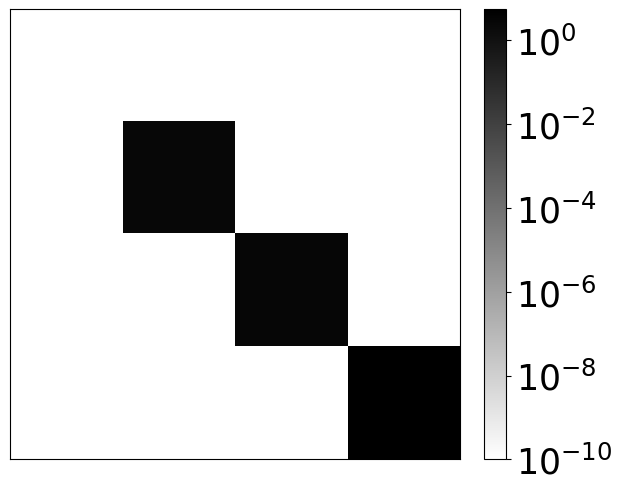

In [22]:
npad2_cz_ham = npad2_ham[np.ix_(zz_idx, zz_idx)]
E00, E01, E10, E11 = np.diag(npad2_cz_ham)
print(E11 + E00 - E01 - E10)
plot_matelm_mag(npad2_cz_ham)

The subspace matrix is now diagonal. Let usdo another sweep.

In [23]:
extract_num_params(test_ham, *nonzero_couplings1_idx[0])

(0.05, -0.19999999999999996, -0.24497866312686423, (1+0j))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 2682 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done 9754 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-2)]: Done 9979 out of 10000 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 10000 out of 10000 | elapsed:    7.4s finished


Text(0, 0.5, '$|\\zeta|$ (MHz)')

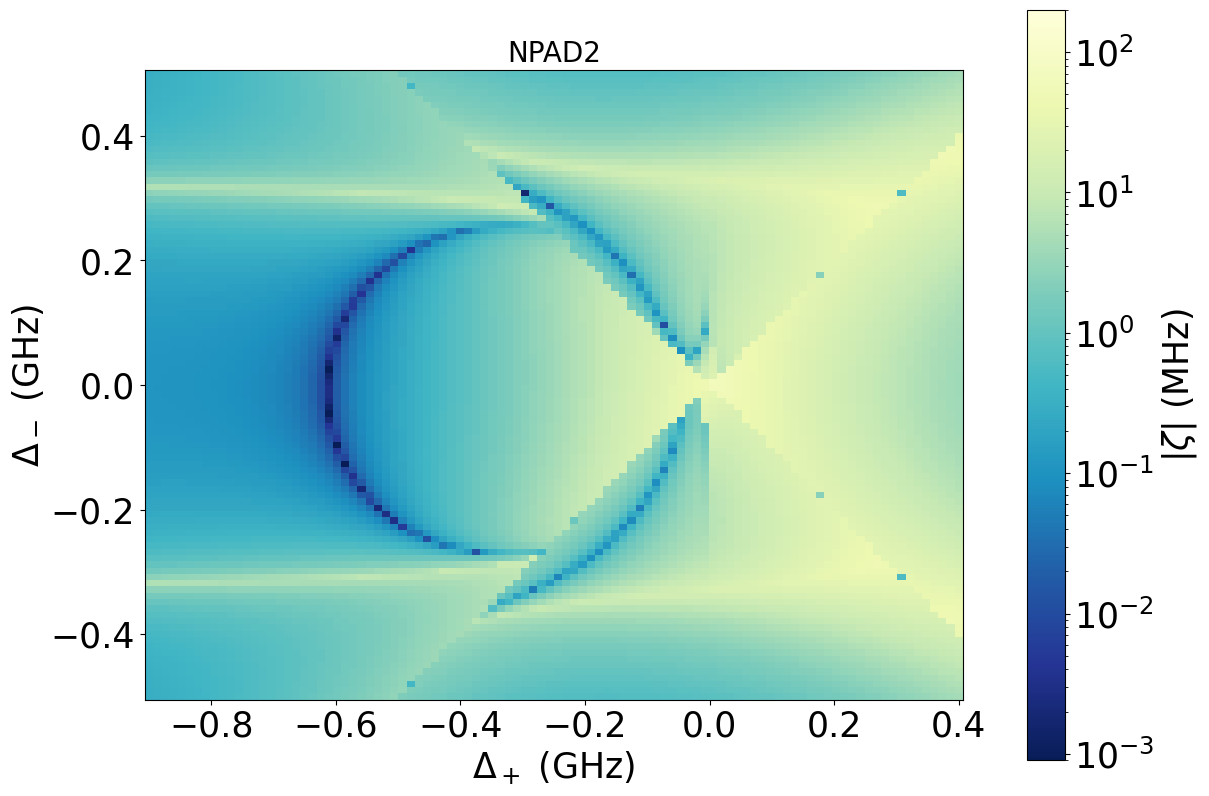

In [24]:
def npad2_zz(delp, delm):
    test_sys = create_duffingresonator_system(delp=delp, delm=delm)
    test_ham = full_numerical_ham(test_sys)
    zz_npad1_couplings = [(4, 1), (16, 1), (20, 5), (20, 17)]
    zz_npad2_couplings = [(16, 4), (20, 2), (20, 8), (32, 20)]
    zz_idx = [0, 4, 16, 20]
    npad1_ham = npad_eliminate_couplings_simultaneous(test_ham, zz_npad1_couplings)
    npad2_ham = npad_eliminate_couplings_simultaneous(npad1_ham, zz_npad2_couplings)
    npad_cz_ham = npad2_ham[np.ix_(zz_idx, zz_idx)]
    E00, E01, E10, E11 = np.diag(npad_cz_ham)
    return E11 + E00 - E01 - E10


N = 100
delp_list = np.linspace(-0.9, 0.4, N)
delm_list = np.linspace(-0.5, 0.5, N)


npad2_zz_list = np.vstack(
    Parallel(n_jobs=-2, verbose=1)(
        delayed(npad2_zz)(delp, delm) for delm in delm_list for delp in delp_list
    )
)

fig, ax = plt.subplots(
    1,
    1,
    layout="constrained",
    figsize=(12, 8),
    sharex=True,
    sharey=True,
)
pm2 = ax.pcolormesh(
    delp_list,
    delm_list,
    np.abs(npad2_zz_list.reshape(delm_list.shape[0], delp_list.shape[0])) * 1e3,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(vmin=9e-4, vmax=2e2),
)
ax.set(
    title="NPAD2",
    aspect="equal",
    xlabel=r"$\Delta_+$ (GHz)",
    ylabel=r"$\Delta_-$ (GHz)",
)

cbar = fig.colorbar(pm2)
cbar.ax.set_ylabel(r"$|\zeta|$ (MHz)")

The smallest case is simple enough so that we can do this manually for the desired transition. While this can be done for most cases, scaling up to very large sizes requires automation. So let's reproduce the plot with our automated funcitons.

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0, 0.5, '$|\\zeta|$ (MHz)')

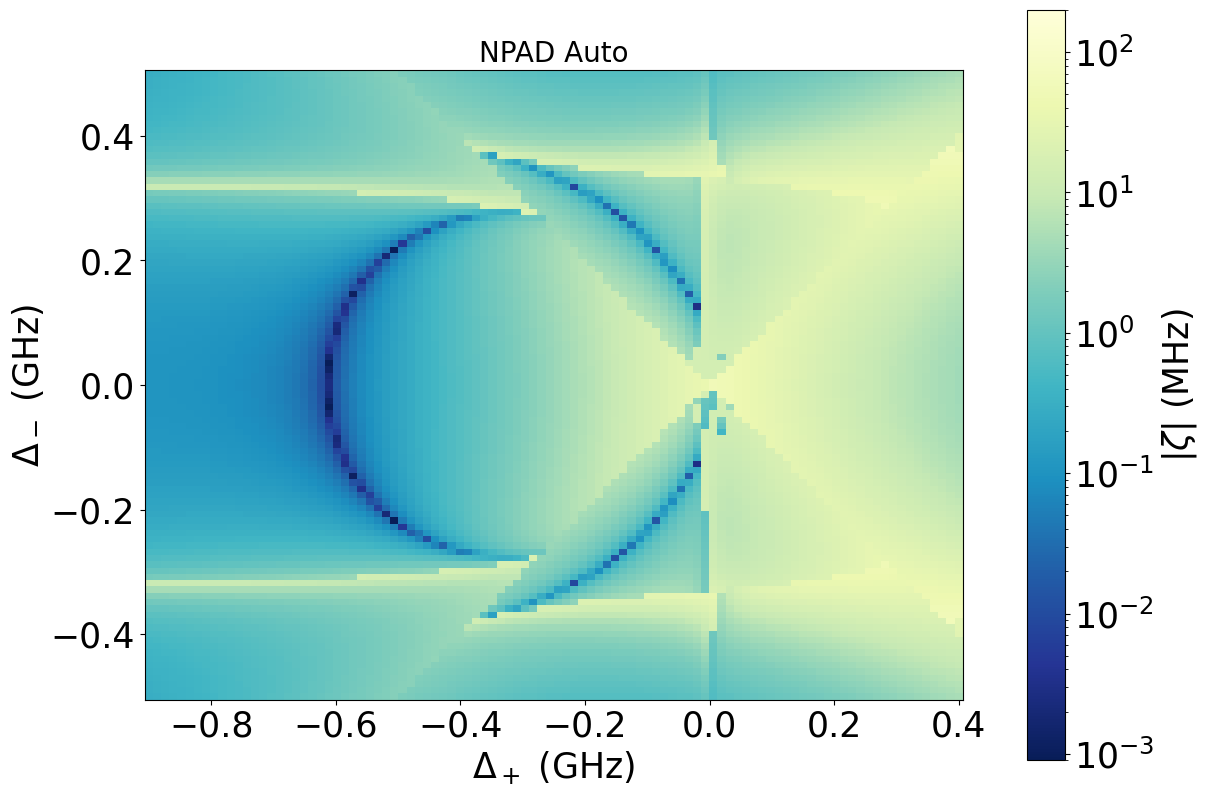

In [28]:
def npad_auto_zz(delp, delm):
    test_sys = create_duffingresonator_system(delp=delp, delm=delm)
    system_dims = [
        test_sys.qubit1.ntrunc,
        test_sys.qubit2.ntrunc,
        test_sys.resonator.ntrunc,
    ]
    all_levels = list(qt.state_number_enumerate(system_dims))
    zz_levels = [label for label in all_levels if label[2] == 0 and max(label) <= 1]
    other_levels = [label for label in all_levels if label not in zz_levels]
    zz_idx = np.asarray(
        [qt.state_number_index(system_dims, label) for label in zz_levels]
    )
    other_idx = np.asarray(
        [qt.state_number_index(system_dims, label) for label in other_levels]
    )
    test_ham = full_numerical_ham(test_sys)
    npad_zz_ham = npad_decouple_sim(
        test_ham, zz_idx, other_idx, batch_size=4, eps=1e-16
    )[np.ix_(zz_idx, zz_idx)]
    npad_cz_ham = npad_diagonalize(npad_zz_ham, eps=1e-12)
    E00, E01, E10, E11 = np.diag(npad_cz_ham)
    return E11 + E00 - E01 - E10


N = 100
delp_list = np.linspace(-0.9, 0.4, N)
delm_list = np.linspace(-0.5, 0.5, N)


npad_auto_zz_list = np.vstack(
    Parallel(n_jobs=-2, verbose=0)(
        delayed(npad_auto_zz)(delp, delm)
        for delm, delp in tqdm(
            product(delm_list, delp_list),
            total=(delm_list.shape[0] * delp_list.shape[0]),
        )
    )
)

fig, ax = plt.subplots(
    1,
    1,
    layout="constrained",
    figsize=(12, 8),
    sharex=True,
    sharey=True,
)
pm2 = ax.pcolormesh(
    delp_list,
    delm_list,
    np.abs(npad_auto_zz_list.reshape(delm_list.shape[0], delp_list.shape[0])) * 1e3,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(vmin=9e-4, vmax=2e2),
)
ax.set(
    title="NPAD Auto",
    aspect="equal",
    xlabel=r"$\Delta_+$ (GHz)",
    ylabel=r"$\Delta_-$ (GHz)",
)

cbar = fig.colorbar(pm2)
cbar.ax.set_ylabel(r"$|\zeta|$ (MHz)")

While this is not perfect, we can later optimize rotations manually.